## Phase 1: Data

**Dataset Overview**
- Size: 5,842 financial headlines
- Columns: Sentence (text), Sentiment (3-class labels)
- Quality: No missing values
- Class distribution: Neutral (53.6%), Positive (31.7%), Negative (14.7%)

### Sub-step 1: Dataset Loading & Initial Inspection

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
df = pd.read_csv('../data/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Dataset Structure
The data contains two columns:
- **Sentence:** Financial headlines/sentences
- **Sentiment:** Three-class labels (positive, neutral, negative)

In [92]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

### Data Quality Check
No missing values found.

In [93]:
df.shape

(5842, 2)

### Dataset Size
- **Total samples:** 5,842 financial headlines

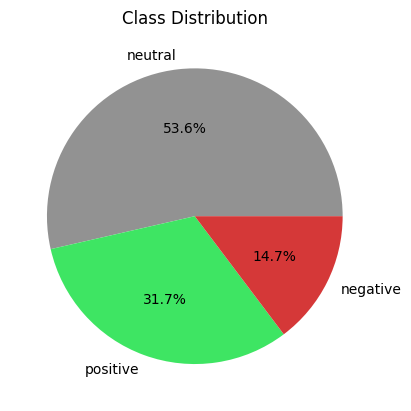

In [94]:
colors = ['#929292', '#3EE563', '#D53838']
df['Sentiment'].value_counts(normalize=True).plot(
    kind='pie',
    colors=colors,
    autopct='%1.1f%%'
)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

There are twice as many **positive** than **negative** sentences. More than half the sentences are **neutral**.

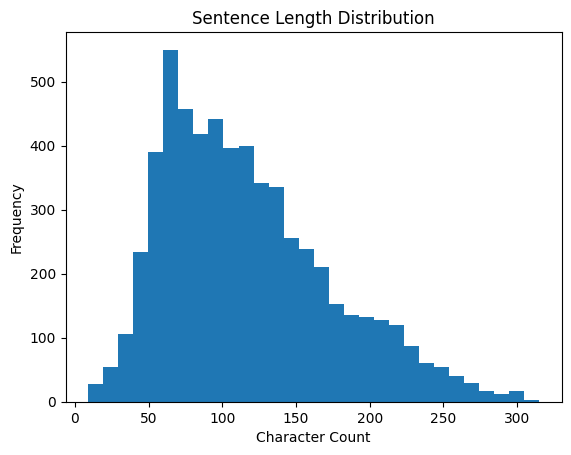

In [95]:
df['Sentence'].str.len().describe()
plt.hist(df['Sentence'].str.len(), bins=30)
plt.title('Sentence Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

**Average** sentence length is *117* characters. **Max** is *315*, **min** is *9*.

## Train/Test Splits

In [96]:
from sklearn.model_selection import train_test_split

# Created stratified train/validation/test splits (70/15/15)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3,
    stratify=df['Sentiment'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5,
    stratify=temp_df['Sentiment'],
    random_state=42
)

In [97]:
# Check split sizes
print("Original:", len(df))
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

# Check class distribution in each split
print("\nClass distribution:")
print("Train:", train_df['Sentiment'].value_counts(normalize=True))
print("Val:", val_df['Sentiment'].value_counts(normalize=True))
print("Test:", test_df['Sentiment'].value_counts(normalize=True))

Original: 5842
Train: 4089
Validation: 876
Test: 877

Class distribution:
Train: Sentiment
neutral     0.535828
positive    0.316948
negative    0.147224
Name: proportion, dtype: float64
Val: Sentiment
neutral     0.535388
positive    0.317352
negative    0.147260
Name: proportion, dtype: float64
Test: Sentiment
neutral     0.535918
positive    0.316990
negative    0.147092
Name: proportion, dtype: float64


In [98]:
# Save splits for later use
train_df.to_csv('../data/train.csv', index=False)
val_df.to_csv('../data/val.csv', index=False)
test_df.to_csv('../data/test.csv', index=False)

In [99]:
print("=== REPRESENTATIVE EXAMPLES ===")
for sentiment in ['positive', 'neutral', 'negative']:
    print(f"\n{sentiment.upper()} examples:")
    examples = df[df['Sentiment'] == sentiment].sample(3)
    for i, (_, row) in enumerate(examples.iterrows(), 1):
        print(f"{i}. {row['Sentence'][:100]}...")

=== REPRESENTATIVE EXAMPLES ===

POSITIVE examples:
1. Stora Enso owns 43 percent of Bergvik and earns therefore SEK 1.5 bn on the value appreciation ....
2. Finnish IT solutions provider Affecto Oyj said today that it has won a frame contract , valued at so...
3. The stock rose for a second day on Wednesday bringing its two-day rise to GBX12 .0 or 2.0 % ....

NEUTRAL examples:
1. The company serves customers in various industries , including process and resources , industrial ma...
2. The company reported net sales of EUR550m in 2005 and had some 3,200 employees ....
3. It offers advanced machinery maintenance and process development services to the pulp and paper indu...

NEGATIVE examples:
1. $AAPL weekly still under the 50 moving average and creating a lower high. https://t.co/vT7ppzY2UY...
2. The current reference grade instruments are challenging to operate due to their high price and compl...
3. Earnings per share ( EPS ) in 2005 decreased to EUR1 .87 from EUR1 .89 in 2003 ....


## Preprocessing Pipeline

### Text Cleaning
- Convert to lowercase
- Handle punctuation and special characters
- Remove extra whitespace

### Tokenization Strategy
- **TF-IDF baseline:** Word-based tokenization
- **FinBERT:** Subword tokenization (handled by model)

### Feature Extraction
- **TF-IDF:** Term frequency-inverse document frequency vectors
- **FinBERT:** Pre-trained embeddings + fine-tuning

## Baseline Models


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


### Baseline Model Setup

In this section, we will:
- Load the train, validation, and test splits.
- Extract features using TF-IDF vectorization.
- Define a set of baseline classifiers for comparison.
This provides a reference point for evaluating more advanced models like FinBERT.


In [101]:
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


# Extract features and labels
X_train = train_df['Sentence']
y_train = train_df['Sentiment']
X_val = val_df['Sentence']
y_val = val_df['Sentiment']
X_test = test_df['Sentence']
y_test = test_df['Sentiment']

Train: (4089, 2)
Validation: (876, 2)
Test: (877, 2)


In [102]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    lowercase=True,
    stop_words='english',
    token_pattern=r'\b\w+\b',  # Only word characters
    strip_accents='unicode'     # Remove accents
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Val TF-IDF shape:", X_val_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (4089, 5000)
Val TF-IDF shape: (876, 5000)
Test TF-IDF shape: (877, 5000)


In [103]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced'),
    'Linear SVM': LinearSVC(random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced')
}

In [104]:
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    print(f"✓ {name} trained successfully")

Training Logistic Regression...
✓ Logistic Regression trained successfully
Training Random Forest...
✓ Random Forest trained successfully
Training SVM...
✓ SVM trained successfully
Training Linear SVM...
✓ Linear SVM trained successfully
Training Naive Bayes...
✓ Naive Bayes trained successfully
Training Gradient Boosting...
✓ Gradient Boosting trained successfully
Training Decision Tree...
✓ Decision Tree trained successfully


In [105]:
predictions = {}
for name, model in trained_models.items():
    predictions[name] = model.predict(X_val_tfidf)
    print(f"✓ {name} predictions completed")

✓ Logistic Regression predictions completed
✓ Random Forest predictions completed
✓ SVM predictions completed
✓ Linear SVM predictions completed
✓ Naive Bayes predictions completed
✓ Gradient Boosting predictions completed
✓ Decision Tree predictions completed


In [106]:
from sklearn.metrics import accuracy_score

# Compare accuracy across all models
results = {}
for name, pred in predictions.items():
    accuracy = accuracy_score(y_val, pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.3f}")

# Find best model
best_model = max(results, key=lambda k: results[k])      # or key=results.__getitem__
print(f"\n🏆 Best model: {best_model} ({results[best_model]:.3f})")

Logistic Regression Accuracy: 0.683
Random Forest Accuracy: 0.653
SVM Accuracy: 0.682
Linear SVM Accuracy: 0.655
Naive Bayes Accuracy: 0.697
Gradient Boosting Accuracy: 0.674
Decision Tree Accuracy: 0.562

🏆 Best model: Naive Bayes (0.697)


In [107]:
# Detailed report for best model
print(f"Classification Report - {best_model}:")
print(classification_report(y_val, predictions[best_model]))

Classification Report - Naive Bayes:
              precision    recall  f1-score   support

    negative       0.83      0.04      0.07       129
     neutral       0.67      0.98      0.80       469
    positive       0.77      0.53      0.63       278

    accuracy                           0.70       876
   macro avg       0.76      0.52      0.50       876
weighted avg       0.73      0.70      0.64       876



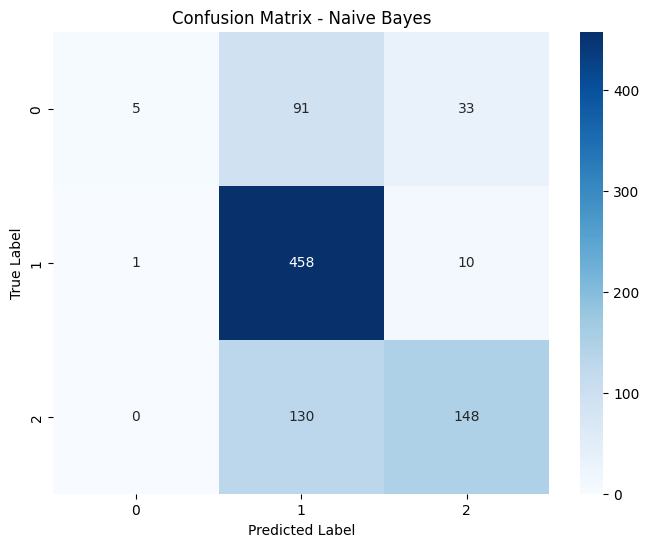

In [108]:
import seaborn as sns

# Create confusion matrix for best model
cm = confusion_matrix(y_val, predictions[best_model])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [109]:
# Create performance comparison table
import pandas as pd

performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values())
}).sort_values('Accuracy', ascending=False)

print("=== MODEL PERFORMANCE COMPARISON ===")
print(performance_df.to_string(index=False))

=== MODEL PERFORMANCE COMPARISON ===
              Model  Accuracy
        Naive Bayes  0.697489
Logistic Regression  0.682648
                SVM  0.681507
  Gradient Boosting  0.673516
         Linear SVM  0.655251
      Random Forest  0.652968
      Decision Tree  0.561644


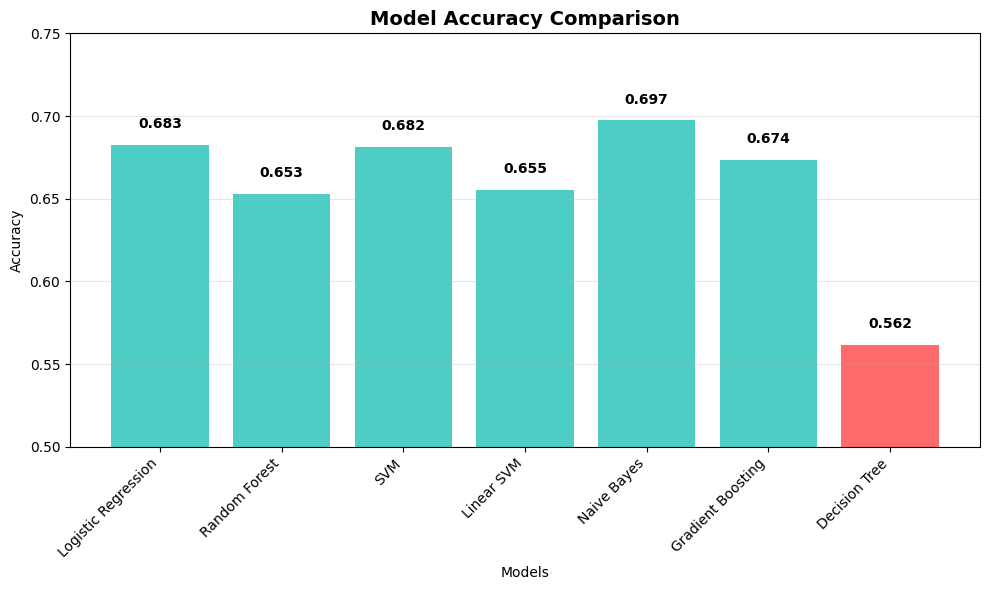

In [110]:
# Bar chart of model accuracies
plt.figure(figsize=(10, 6))
models_list = list(results.keys())
accuracies = list(results.values())
colors = ['#ff6b6b' if acc < 0.65 else '#4ecdc4' if acc < 0.70 else '#45b7d1' for acc in accuracies]

plt.bar(models_list, accuracies, color=colors)
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 0.75)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### NEXT STEPS

1. **Move to FinBERT for improved performance**
2. **Focus on negative class recall improvement**
3. **Consider data augmentation for negative class**
4. **Test on held-out test set**